# EfficientNetB0 Transfer Learning: Baseline, Fine‑Tuning

This notebook reproduces the EfficientNetB0 transfer‑learning pipeline on Flowers102 and evaluates freezing strategies.

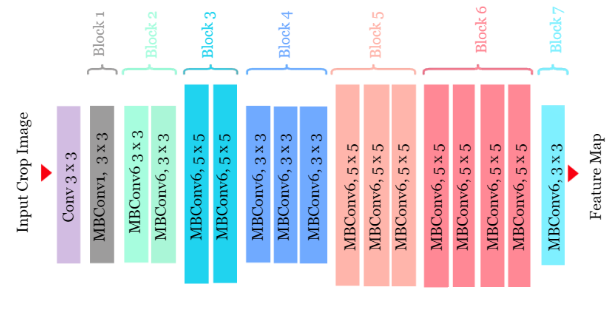

## Imports and Reproducibility Setup

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time

from torch.utils.data import Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE


seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

## Data Preparation and Helper Functions

In [2]:
# resize images to 224x224 in line with ResNet/EfficientNet input size, normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [3]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset   = datasets.Flowers102(root='./data', split='val',   download=True, transform=transform)
test_dataset  = datasets.Flowers102(root='./data', split='test',  download=True, transform=transform)


In [4]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


In [5]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [6]:
NUM_CLASSES = 102
BASE_LR = 5e-4          # base LR for top layers
WEIGHT_DECAY = 0.0
MAX_EPOCHS = 100
PATIENCE = 5
LAYER_DECAY = 0.8       # Layer-wise LR decay factor (earlier layers get LR * LAYER_DECAY^k)


In [7]:
# Model Builder

def build_efficientnet_b0(num_classes=NUM_CLASSES, dropout_p=0.5):
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)
    in_features = model.classifier[1].in_features

    # replace classifier: Dropout + Linear(num_classes)
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_p, inplace=True),
        nn.Linear(in_features, num_classes)
    )
    return model

In [8]:
# Freezing Strategies

def freeze_all_features(model):
    """Freeze all feature extractor layers; train classifier only."""
    for name, param in model.named_parameters():
        if not name.startswith("classifier"):
            param.requires_grad = False
        else:
            param.requires_grad = True

def partial_unfreeze_last_stage(model):
    """
    Freeze all but:
      - the last EfficientNet block (features[-1])
      - the classifier
    """
    # freeze everything
    for param in model.parameters():
        param.requires_grad = False

    # unfreeze last block
    for param in model.features[-1].parameters():
        param.requires_grad = True

    # unfreeze classifier
    for param in model.classifier.parameters():
        param.requires_grad = True

def unfreeze_all(model):
    """Unfreeze the entire network."""
    for param in model.parameters():
        param.requires_grad = True


In [9]:
# Layer-wise LR Decay

def make_llrd_param_groups(model, base_lr=BASE_LR, weight_decay=WEIGHT_DECAY, layer_decay=LAYER_DECAY):
    """
    Create param groups with layer-wise LR decay for all trainable params.
    Later (closer to classifier) layers get higher LR; earlier layers get decayed LR.
    Only includes parameters with requires_grad=True.
    """
    layers = []

    # feature blocks in order
    for block in model.features:
        params = [p for p in block.parameters() if p.requires_grad]
        if len(params) > 0:
            layers.append(params)

    # classifier as last layer group
    clf_params = [p for p in model.classifier.parameters() if p.requires_grad]
    if len(clf_params) > 0:
        layers.append(clf_params)

    # if nothing (e.g. fully frozen), just return empty list
    if len(layers) == 0:
        return []

    num_layers = len(layers)
    param_groups = []

    # earliest layer -> smallest lr; latest layer -> base_lr
    for i, params in enumerate(layers):
        scale = layer_decay ** (num_layers - i - 1)
        lr = base_lr * scale
        param_groups.append({
            "params": params,
            "lr": lr,
            "weight_decay": weight_decay
        })

    return param_groups

In [10]:
# Train / Eval Functions

def train_one_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    model_path="model_effb0.pth"
):
    criterion = nn.CrossEntropyLoss()
    earlystopper = EarlyStopper(patience=patience, min_delta=0.0,
                                verbose=True, model_path=model_path)

    train_loss_hist, train_acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []

    for epoch in range(1, num_epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X, y in train_loader:
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == y).sum().item()
            total += X.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        train_loss_hist.append(epoch_train_loss)
        train_acc_hist.append(epoch_train_acc)

        # ---- Validation ----
        model.eval()
        v_running_loss = 0.0
        v_correct = 0
        v_total = 0

        with torch.no_grad():
            for X_val, y_val in val_loader:

                logits_val = model(X_val)
                v_loss = criterion(logits_val, y_val)

                v_running_loss += v_loss.item() * X_val.size(0)
                _, v_preds = torch.max(logits_val, 1)
                v_correct += (v_preds == y_val).sum().item()
                v_total += X_val.size(0)

        epoch_val_loss = v_running_loss / v_total
        epoch_val_acc = v_correct / v_total
        val_loss_hist.append(epoch_val_loss)
        val_acc_hist.append(epoch_val_acc)

        print(
            f"Epoch {epoch:02d}/{num_epochs} | "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
        )

        if earlystopper.early_stop(epoch_val_loss, model):
            break

    best_val_acc = max(val_acc_hist) if val_acc_hist else 0.0
    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist, best_val_acc


def evaluate_model(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            loss = criterion(logits, y)
            running_loss += loss.item() * X.size(0)

            _, preds = torch.max(logits, 1)
            correct += (preds == y).sum().item()
            total += X.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def load_best_model(model_path):
    model = build_efficientnet_b0(num_classes=NUM_CLASSES, dropout_p=0.5)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.eval()
    return model

## Training Loop
Here are the variants tested:
| Modification      | Variant       | 
|-----------------|-----------------|
| Fine-tuning Strategy | Full, Partial, Frozen | 

In [11]:
# Run 3 Training Regimes

results = {}

# 1) Frozen features, train classifier only
print("\n=== EfficientNet-B0: Frozen Features (Classifier Only) ===")
model_frozen = build_efficientnet_b0()
freeze_all_features(model_frozen)
pg_frozen = [p for p in model_frozen.parameters() if p.requires_grad]
optimizer_frozen = optim.Adam(pg_frozen, lr=BASE_LR, weight_decay=WEIGHT_DECAY)

(
    tr_l_frozen,
    tr_a_frozen,
    vl_l_frozen,
    vl_a_frozen,
    best_val_acc_frozen
) = train_one_model(
    model_frozen,
    train_loader,
    val_loader,
    optimizer_frozen,
    num_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    model_path="effb0_frozen.pth"
)

best_model_frozen = load_best_model("effb0_frozen.pth")
test_loss_frozen, test_acc_frozen = evaluate_model(best_model_frozen, test_loader)

results["Frozen"] = {
    "train_loss": tr_l_frozen,
    "train_acc": tr_a_frozen,
    "val_loss": vl_l_frozen,
    "val_acc": vl_a_frozen,
    "best_val_acc": best_val_acc_frozen,
    "test_acc": test_acc_frozen,
    "model_path": "effb0_frozen.pth"
}

print(f"[Frozen] Best Val Acc: {best_val_acc_frozen:.4f}, Test Acc: {test_acc_frozen:.4f}")


# 2) Partial unfreeze (last stage + classifier) with LLRD
print("\n=== EfficientNet-B0: Partial Unfreeze (Last Stage + Classifier, LLRD) ===")
model_partial = build_efficientnet_b0()
partial_unfreeze_last_stage(model_partial)
pg_partial = make_llrd_param_groups(model_partial, base_lr=BASE_LR,
                                    weight_decay=WEIGHT_DECAY, layer_decay=LAYER_DECAY)
optimizer_partial = optim.Adam(pg_partial)

(
    tr_l_partial,
    tr_a_partial,
    vl_l_partial,
    vl_a_partial,
    best_val_acc_partial
) = train_one_model(
    model_partial,
    train_loader,
    val_loader,
    optimizer_partial,
    num_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    model_path="effb0_partial_llrd.pth"
)

best_model_partial = load_best_model("effb0_partial_llrd.pth")
test_loss_partial, test_acc_partial = evaluate_model(best_model_partial, test_loader)

results["Partial+LLRD"] = {
    "train_loss": tr_l_partial,
    "train_acc": tr_a_partial,
    "val_loss": vl_l_partial,
    "val_acc": vl_a_partial,
    "best_val_acc": best_val_acc_partial,
    "test_acc": test_acc_partial,
    "model_path": "effb0_partial_llrd.pth"
}

print(f"[Partial+LLRD] Best Val Acc: {best_val_acc_partial:.4f}, Test Acc: {test_acc_partial:.4f}")


# 3) Full fine-tune with LLRD over all layers
print("\n=== EfficientNet-B0: Full Fine-tune (All Layers, LLRD) ===")
model_full = build_efficientnet_b0()
unfreeze_all(model_full)
pg_full = make_llrd_param_groups(model_full, base_lr=BASE_LR,
                                 weight_decay=WEIGHT_DECAY, layer_decay=LAYER_DECAY)
optimizer_full = optim.Adam(pg_full)

(
    tr_l_full,
    tr_a_full,
    vl_l_full,
    vl_a_full,
    best_val_acc_full
) = train_one_model(
    model_full,
    train_loader,
    val_loader,
    optimizer_full,
    num_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    model_path="effb0_full_llrd.pth"
)

best_model_full = load_best_model("effb0_full_llrd.pth")
test_loss_full, test_acc_full = evaluate_model(best_model_full, test_loader)

results["Full+LLRD"] = {
    "train_loss": tr_l_full,
    "train_acc": tr_a_full,
    "val_loss": vl_l_full,
    "val_acc": vl_a_full,
    "best_val_acc": best_val_acc_full,
    "test_acc": test_acc_full,
    "model_path": "effb0_full_llrd.pth"
}

print(f"[Full+LLRD] Best Val Acc: {best_val_acc_full:.4f}, Test Acc: {test_acc_full:.4f}")



=== EfficientNet-B0: Frozen Features (Classifier Only) ===
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\nguiy/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 13.8MB/s]


Epoch 01/100 | Train Loss: 4.5287, Train Acc: 0.0392 | Val Loss: 4.1986, Val Acc: 0.2569
Epoch 02/100 | Train Loss: 3.8994, Train Acc: 0.3676 | Val Loss: 3.7605, Val Acc: 0.5333
Epoch 03/100 | Train Loss: 3.3626, Train Acc: 0.6618 | Val Loss: 3.3830, Val Acc: 0.6451
Epoch 04/100 | Train Loss: 2.8924, Train Acc: 0.8020 | Val Loss: 3.0480, Val Acc: 0.7029
Epoch 05/100 | Train Loss: 2.5025, Train Acc: 0.8794 | Val Loss: 2.7506, Val Acc: 0.7382
Epoch 06/100 | Train Loss: 2.1637, Train Acc: 0.9039 | Val Loss: 2.5024, Val Acc: 0.7529
Epoch 07/100 | Train Loss: 1.8693, Train Acc: 0.9225 | Val Loss: 2.2732, Val Acc: 0.7676
Epoch 08/100 | Train Loss: 1.6279, Train Acc: 0.9451 | Val Loss: 2.1142, Val Acc: 0.7696
Epoch 09/100 | Train Loss: 1.4074, Train Acc: 0.9520 | Val Loss: 1.9804, Val Acc: 0.7814
Epoch 10/100 | Train Loss: 1.2208, Train Acc: 0.9588 | Val Loss: 1.8487, Val Acc: 0.7843
Epoch 11/100 | Train Loss: 1.0985, Train Acc: 0.9667 | Val Loss: 1.7247, Val Acc: 0.7990
Epoch 12/100 | Train 

## Data Visualisation and Plots

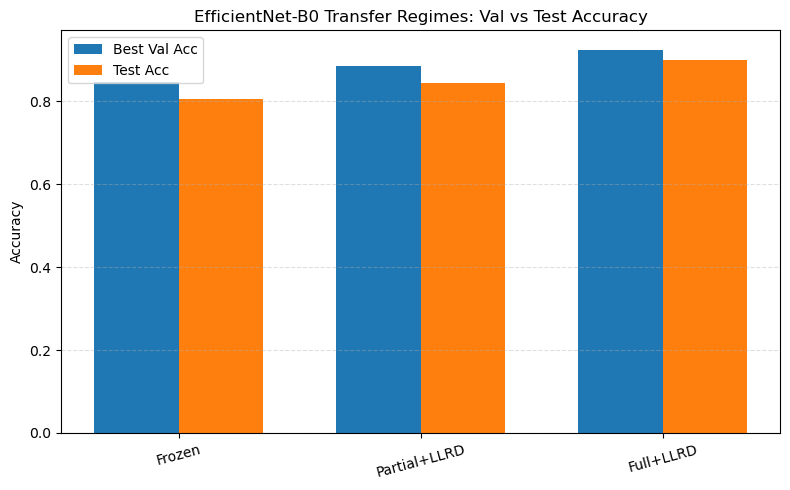

In [12]:
# Visualisations for Comparison
variant_names = list(results.keys())
best_vals = [results[k]["best_val_acc"] for k in variant_names]
test_accs = [results[k]["test_acc"] for k in variant_names]

# Plot 1: Best Val Accuracy + Test Accuracy per Variant
plt.figure(figsize=(8, 5))
x = np.arange(len(variant_names))
width = 0.35
plt.bar(x - width/2, best_vals, width=width, label="Best Val Acc")
plt.bar(x + width/2, test_accs, width=width, label="Test Acc")
plt.xticks(x, variant_names, rotation=15)
plt.ylabel("Accuracy")
plt.title("EfficientNet-B0 Transfer Regimes: Val vs Test Accuracy")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



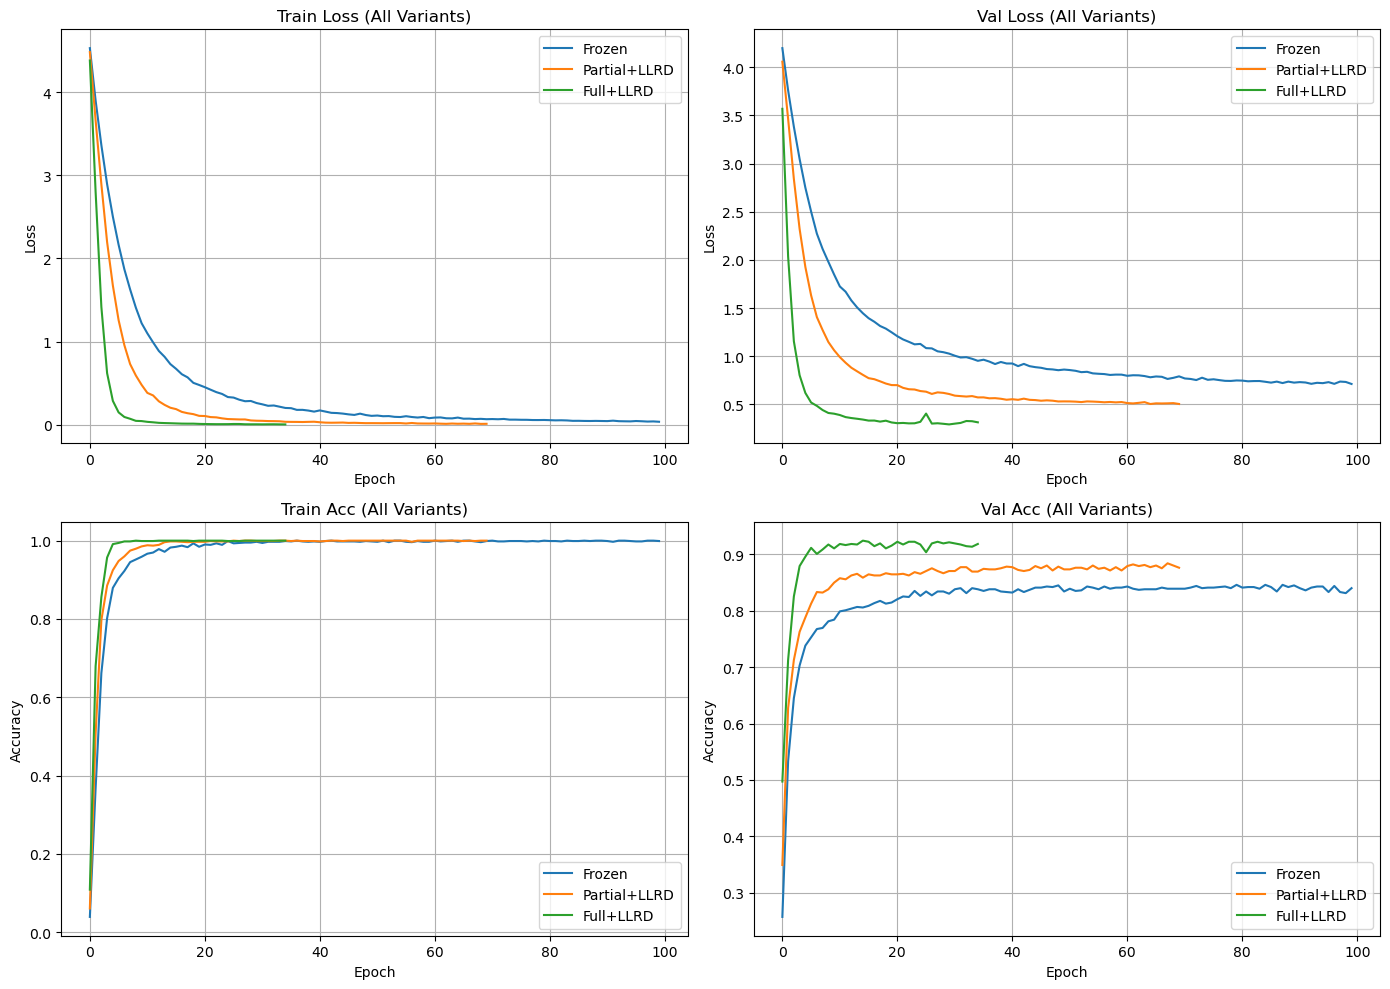

In [13]:
# Plot 2: Train/Val Loss & Acc Histories for All Variants
plt.figure(figsize=(14, 10))

# Train Loss
ax1 = plt.subplot(2, 2, 1)
for name in variant_names:
    ax1.plot(results[name]["train_loss"], label=name)
ax1.set_title("Train Loss (All Variants)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Val Loss
ax2 = plt.subplot(2, 2, 2)
for name in variant_names:
    ax2.plot(results[name]["val_loss"], label=name)
ax2.set_title("Val Loss (All Variants)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train Acc
ax3 = plt.subplot(2, 2, 3)
for name in variant_names:
    ax3.plot(results[name]["train_acc"], label=name)
ax3.set_title("Train Acc (All Variants)")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Accuracy")
ax3.grid(True)
ax3.legend()

# Val Acc
ax4 = plt.subplot(2, 2, 4)
for name in variant_names:
    ax4.plot(results[name]["val_acc"], label=name)
ax4.set_title("Val Acc (All Variants)")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Accuracy")
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()


Best variant by validation accuracy: Full+LLRD


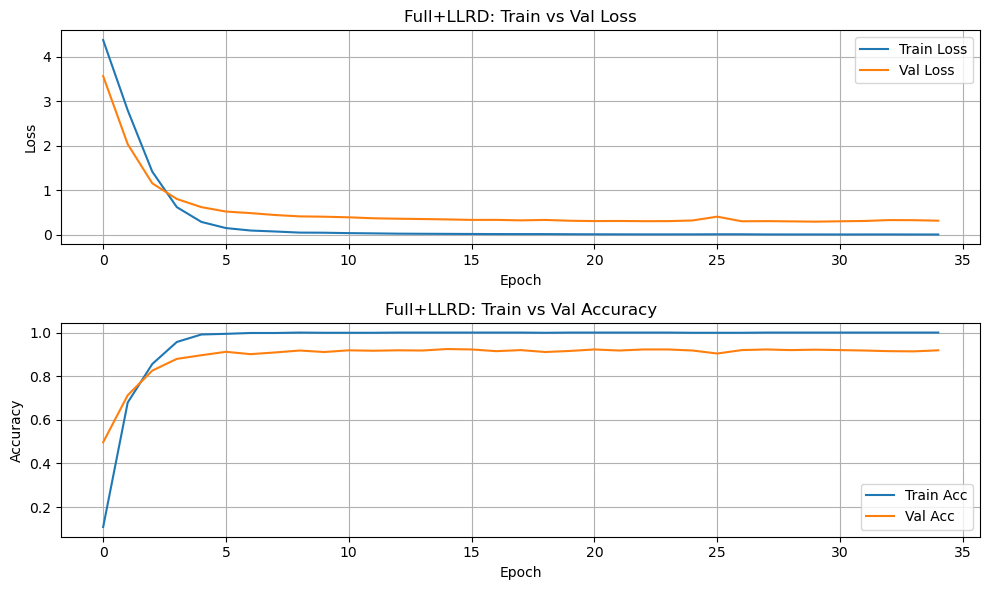

In [14]:
# Plot 3: Detailed History for Best-Performing Variant
best_variant = max(results.items(), key=lambda x: x[1]["best_val_acc"])[0]
print("Best variant by validation accuracy:", best_variant)

bv = results[best_variant]

plt.figure(figsize=(10, 6))

# Loss
ax1 = plt.subplot(2, 1, 1)
ax1.plot(bv["train_loss"], label="Train Loss")
ax1.plot(bv["val_loss"], label="Val Loss")
ax1.set_title(f"{best_variant}: Train vs Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Accuracy
ax2 = plt.subplot(2, 1, 2)
ax2.plot(bv["train_acc"], label="Train Acc")
ax2.plot(bv["val_acc"], label="Val Acc")
ax2.set_title(f"{best_variant}: Train vs Val Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
